# Variational Quantum Algorithms with Qiskit Runtime:<br>Combinatorial Optimization

In this exercise, use Qiskit Runtime to find the approximate solution to a combinatorial optimization problem. 

For example, you could either use a pre-generated instance of a 4-node maxcut graph with weight matrix given by

```
w = [[0. 1. 1. 1.]
     [1. 0. 1. 0.]
     [1. 1. 0. 1.]
     [1. 0. 1. 0.]]
```

Or, start with the below QUBO with binary variables `x`, `y`, and `z`:

```
Minimize: 
  x - 2 y + 3 z + [ 2 x*y - 2 x*z + 4 y*z ]/2
```

_Hints_

- Start with the [notebook implementing a generic VQA with Qiskit Runtime](Part3_VQA_Generic.ipynb) and modify the input problem to be a combinatorial optimization problem.
<br>

- If you choose to solve the QUBO, check out this tutorial from Qiskit Optimization on [how to construct Quadratic Programs](https://qiskit.org/documentation/optimization/tutorials/01_quadratic_program.html).
<br>

- If you choose to solve the maxcut instance, check out this tutorial for [setting up a maxcut problem and mapping to an Ising hamiltonian](https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html).
<br>

- For either problem, you can use the [`Estimator` primitive](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/how-to-getting-started-with-estimator.html) to minimize the energy of the problem. Then, you can use the [`Sampler` primitive](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/how-to-getting-started-with-sampler.html) to get the bitstrings from the approximate ground state. From these bitstrings, you can compute the objective values and probabilities. Finally, the solution is given by the bitstring that yields the best objective function value.
<br>

- For your choice of circuit ansatz, you might start with the [`TwoLocal` circuit](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) or [`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html), but feel free to check out the other [options in the Qiskit Circuit Library](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits). 
<br>

- The [SPSA optimizer](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) is a good choice to try for the classical optimizer. If you choose this, define your callback function with the following arguments:

```
# save outputs of SPSA to a dictionary with 5 keys:
history = {"nfevs": [], "points": [], "fvals": [], "updates": [], "accepted": []}

def callback(nfev, point, fval, update, accepted):
    print('expectation value: {}'.format(fval))
    history["nfevs"].append(nfev)
    history["points"].append(point)
    history["fvals"].append(fval)
    history["updates"].append(update)
    history["accepted"].append(accepted)     
```

## A solution for the 4-node maxcut graph

#### Set up the quadratic program from the weight matrix of the maxcut instance

In [1]:
import numpy as np
w = np.array([[0., 1., 1., 1.], 
     [1., 0., 1., 0.],
     [1., 1., 0., 1.],
     [1., 0., 1., 0.]])

from qiskit_optimization.applications import Maxcut
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 3 x_0 + 2 x_1 + 3 x_2 + 2 x_3 + [ - 4 x_0*x_1 - 4 x_0*x_2 - 4 x_0*x_3
      - 4 x_1*x_2 - 4 x_2*x_3 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



#### Convert the quadratic program to an Ising hamiltonian

In [2]:
qubitOp, offset = qp.to_ising()
num_qubits = qubitOp.num_qubits
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII


#### Solve for the exact solution using the classical eigensolver

In [5]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

fval=4.0, x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, status=SUCCESS


#### To solve with Qiskit Runtime, convert the Ising hamiltonian into an opflow op

In [6]:
from qiskit.opflow import PauliSumOp
import numpy as np

ops = []
h = qubitOp.primitive
h.coeffs = np.real(qubitOp.coeffs)
ops.append(PauliSumOp(h))
print(ops)

[PauliSumOp(SparsePauliOp(['IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j]), coeff=1.0)]


#### Set up the qiskit runtime service and minimize the energy using the `Estimator` primitive

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
options = {"backend" : "ibmq_qasm_simulator"}

from qiskit.circuit.library import TwoLocal
circuit = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
circuit.decompose().draw(fold=300)

┌──────────┐   ┌──────────┐                        ┌──────────┐                         ┌───────────┐                          ┌───────────┐                          ┌───────────┐                          
q_0: ┤ Ry(θ[0]) ├─■─┤ Ry(θ[4]) ├─────────────────■──────┤ Ry(θ[8]) ├──────────────────■──────┤ Ry(θ[12]) ├───────────────────■──────┤ Ry(θ[16]) ├───────────────────■──────┤ Ry(θ[20]) ├──────────────────────────
     ├──────────┤ │ └──────────┘┌──────────┐     │      └──────────┘┌──────────┐      │      └───────────┘┌───────────┐      │      └───────────┘┌───────────┐      │      └───────────┘┌───────────┐             
q_1: ┤ Ry(θ[1]) ├─■──────■──────┤ Ry(θ[5]) ├─────■───────────■──────┤ Ry(θ[9]) ├──────■────────────■──────┤ Ry(θ[13]) ├──────■────────────■──────┤ Ry(θ[17]) ├──────■────────────■──────┤ Ry(θ[21]) ├─────────────
     ├──────────┤        │      └──────────┘┌──────────┐     │      └──────────┘┌───────────┐      │      └───────────┘┌───────────┐      │      └───────────┘┌───────────┐      │      └───────────┘┌───────────┐
q_2: ┤ Ry(θ[2]) ├────────■───────────■──────┤ Ry(θ[6]) ├─────■───────────■──────┤ Ry(θ[10]) ├──────■────────────■──────┤ Ry(θ[14]) ├──────■────────────■──────┤ Ry(θ[18]) ├──────■────────────■──────┤ Ry(θ[22]) ├
     ├──────────┤                    │      ├──────────┤                 │      ├───────────┤                   │      ├───────────┤                   │      ├───────────┤                   │      ├───────────┤
q_3: ┤ Ry(θ[3]) ├────────────────────■──────┤ Ry(θ[7]) ├─────────────────■──────┤ Ry(θ[11]) ├───────────────────■──────┤ Ry(θ[15]) ├───────────────────■──────┤ Ry(θ[19]) ├───────────────────■──────┤ Ry(θ[23]) ├
     └──────────┘                           └──────────┘                        └───────────┘                          └───────────┘                          └───────────┘                          └───────────┘

In [8]:
from qiskit_ibm_runtime import Estimator
from qiskit.algorithms.optimizers import SPSA

history = {"nfevs": [], "points": [], "fvals": [], "updates": [], "accepted": []}

with Estimator(
    circuits=circuit,
    observables=ops,
    options=options,
    service=service
) as estimator:
    
    def evaluate_expectation(x):
        x = list(x)
        results = estimator(circuits=[0], observables=[0], parameter_values=[x]).values[0]
        return np.real(results)

    def callback(nfev, point, fval, update, accepted):
        print('expectation value: {}'.format(fval))
        history["nfevs"].append(nfev)
        history["points"].append(point)
        history["fvals"].append(fval)
        history["updates"].append(update)
        history["accepted"].append(accepted)    

    np.random.seed(1)
    initial_point = np.random.uniform(-np.pi, np.pi, len(circuit.parameters))
    optimizer = SPSA(50, callback=callback)
    result = optimizer.minimize(fun=evaluate_expectation, x0=initial_point)


expectation value: -0.2109375
expectation value: -0.76953125
expectation value: -0.9716796875
expectation value: -0.947265625
expectation value: -1.0654296875
expectation value: -0.9208984375
expectation value: -0.8818359375
expectation value: -0.87109375
expectation value: -0.9296875
expectation value: -0.9345703125
expectation value: -0.9541015625
expectation value: -1.0361328125
expectation value: -1.064453125
expectation value: -1.1181640625
expectation value: -1.1337890625
expectation value: -1.0869140625
expectation value: -1.119140625
expectation value: -1.2138671875
expectation value: -1.1982421875
expectation value: -1.2578125
expectation value: -1.275390625
expectation value: -1.2451171875
expectation value: -1.25390625
expectation value: -1.314453125
expectation value: -1.32421875
expectation value: -1.3046875
expectation value: -1.3291015625
expectation value: -1.3291015625
expectation value: -1.3330078125
expectation value: -1.3408203125
expectation value: -1.3193359375
ex

In [9]:
print('optimized circuit parameters:\n{}'.format(result.x))

optimized circuit parameters:
[-1.08321888 -0.39747851 -4.0763255  -2.32458152 -2.30090626 -4.40358152
  0.48875236  0.37542658 -2.17345486 -0.94103854 -1.14007674  1.97217734
 -1.35189251  1.66033504 -5.01468275  2.43961883 -0.14556013  1.02974334
 -2.01546705 -3.35840138  1.90232805  3.57975248 -0.81951627  2.76292265]


#### Use the `Sampler` primitive to get bitstrings from the approx ground state

In [16]:
from qiskit_ibm_runtime import Sampler

circut = circuit.measure_all()
with Sampler(
    circuits=circuit,
    options=options,
    service=service
) as sampler:
    sampler_result = sampler(circuits=[0], parameter_values=[result.x], shots=8000)
    print(result)

SamplerResult(quasi_dists=[{'1101': 0.000125, '0010': 0.000125, '0111': 0.000125, '1110': 0.0035, '1010': 0.95775, '1001': 0.015625, '0100': 0.005375, '1100': 0.00175, '0101': 0.015625}], metadata=[{'header_metadata': {}, 'shots': 8000}])


In [17]:
bitstrings = sampler_result.quasi_dists[0] # get the dictionary of bitstring counts

#### Plot the convergence and distribution of sampled bitstrings

Text(0, 0.5, 'Probability')

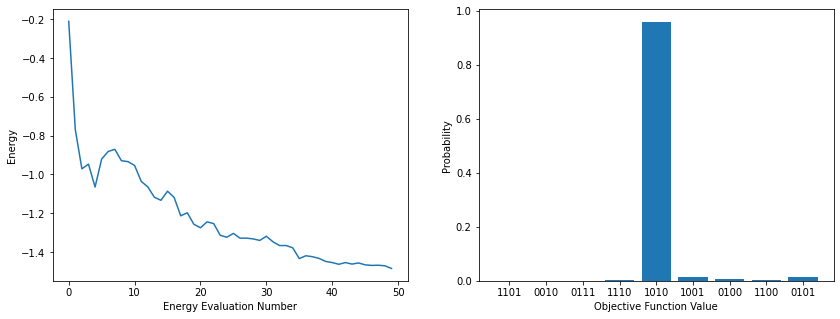

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(history['fvals'])
axs[1].bar(list(bitstrings.keys()), list(bitstrings.values()))
axs[0].set_xlabel("Energy Evaluation Number")
axs[0].set_ylabel("Energy")
axs[1].set_xlabel("Objective Function Value")
axs[1].set_ylabel("Probability")

#### From the bitstrings sampled, compute the corresponding objective function value, and then sort

In [19]:
samples = []
for x, probability in bitstrings.items():

    x = list(map(int, x)) # convert bitstring to list
    status = qp.is_feasible(x)
    fval = qp.objective.evaluate(x)

    samples.append((x, fval, probability, status))

sorted_samples = sorted(
    samples,
    key=lambda v: (1-v[3], qp.objective.sense.value * v[1]) # feasible: 0; infeasible: 1
)

print('\nsorted')
for sample in sorted_samples:
    print(sample)


sorted
([1, 0, 1, 0], 4.0, 0.95775, True)
([0, 1, 0, 1], 4.0, 0.015625, True)
([1, 1, 0, 1], 3.0, 0.000125, True)
([0, 0, 1, 0], 3.0, 0.000125, True)
([0, 1, 1, 1], 3.0, 0.000125, True)
([1, 0, 0, 1], 3.0, 0.015625, True)
([1, 1, 0, 0], 3.0, 0.00175, True)
([1, 1, 1, 0], 2.0, 0.0035, True)
([0, 1, 0, 0], 2.0, 0.005375, True)


#### Get the solution with best objective function value

In [20]:
best = sorted_samples[0]
print('optimal value: {}'.format(best[0]))
print('optimal function value: {}'.format(best[1]))
print('probability of optimal value: {}'.format(best[2]))

optimal value: [1, 0, 1, 0]
optimal function value: 4.0
probability of optimal value: 0.95775


## A solution for the QUBO problem

#### Set up the quadratic program from the description of the QUBO problem

In [21]:
from qiskit_optimization import QuadraticProgram

qp = QuadraticProgram()
qp.binary_var("x")
qp.binary_var("y")
qp.binary_var("z")
qp.minimize(linear=[1, -2, 3], quadratic={("x", "y"): 1, ("x", "z"): -1, ("y", "z"): 2})
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x - 2 y + 3 z + [ 2 x*y - 2 x*z + 4 y*z ]/2
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1

Binaries
 x y z
End



#### Convert the quadratic program to an Ising hamiltonian

In [22]:
qubitOp, offset = qp.to_ising()
num_qubits = qubitOp.num_qubits
print("offset: {}".format(offset))
print("operator:\n{}".format(qubitOp))

offset: 1.5
operator:
-0.5 * IIZ
+ 0.25 * IZI
- 1.75 * ZII
+ 0.25 * IZZ
- 0.25 * ZIZ
+ 0.5 * ZZI


#### Solve for the exact solution using the classical eigensolver

In [23]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

fval=-2.0, x=0.0, y=1.0, z=0.0, status=SUCCESS


#### To solve with Qiskit Runtime, convert the Ising hamiltonian into an opflow op

In [24]:
from qiskit.opflow import PauliSumOp
import numpy as np

ops = []
h = qubitOp.primitive
h.coeffs = np.real(qubitOp.coeffs)
ops.append(PauliSumOp(h))
print(ops)

[PauliSumOp(SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[-0.5 +0.j,  0.25+0.j, -1.75+0.j,  0.25+0.j, -0.25+0.j,  0.5 +0.j]), coeff=1.0)]


#### Set up the qiskit runtime service and minimize the energy using the `Estimator` primitive

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
options = {"backend" : "ibmq_qasm_simulator"}

from qiskit.circuit.library import RealAmplitudes
circuit = RealAmplitudes(num_qubits=num_qubits, reps=2)

circuit.decompose().draw(fold=100)

┌──────────┐          ┌──────────┐                      ┌──────────┐            
q_0: ┤ Ry(θ[0]) ├──■────■──┤ Ry(θ[3]) ├──────────────■────■──┤ Ry(θ[6]) ├────────────
     ├──────────┤┌─┴─┐  │  └──────────┘┌──────────┐┌─┴─┐  │  └──────────┘┌──────────┐
q_1: ┤ Ry(θ[1]) ├┤ X ├──┼───────■──────┤ Ry(θ[4]) ├┤ X ├──┼───────■──────┤ Ry(θ[7]) ├
     ├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤
q_2: ┤ Ry(θ[2]) ├─────┤ X ├───┤ X ├────┤ Ry(θ[5]) ├─────┤ X ├───┤ X ├────┤ Ry(θ[8]) ├
     └──────────┘     └───┘   └───┘    └──────────┘     └───┘   └───┘    └──────────┘

In [26]:
from qiskit_ibm_runtime import Estimator
from qiskit.algorithms.optimizers import SPSA

history = {"nfevs": [], "points": [], "fvals": [], "updates": [], "accepted": []}

with Estimator(
    circuits=circuit,
    observables=ops,
    options=options,
    service=service
) as estimator:
    
    def evaluate_expectation(x):
        x = list(x)
        results = estimator(circuits=[0], observables=[0], parameter_values=[x]).values[0]
        return np.real(results)

    def callback(nfev, point, fval, update, accepted):
        print('expectation value: {}'.format(fval))
        history["nfevs"].append(nfev)
        history["points"].append(point)
        history["fvals"].append(fval)
        history["updates"].append(update)
        history["accepted"].append(accepted)    

    np.random.seed(1)
    initial_point = np.random.uniform(-np.pi, np.pi, len(circuit.parameters))
    optimizer = SPSA(30, callback=callback)
    result = optimizer.minimize(fun=evaluate_expectation, x0=initial_point)


expectation value: -1.2265625
expectation value: -2.9130859375
expectation value: -2.3154296875
expectation value: -2.8515625
expectation value: -2.77734375
expectation value: -2.421875
expectation value: -2.4921875
expectation value: -2.5576171875
expectation value: -2.841796875
expectation value: -3.0380859375
expectation value: -2.9814453125
expectation value: -3.0546875
expectation value: -3.0361328125
expectation value: -3.185546875
expectation value: -3.1748046875
expectation value: -3.2548828125
expectation value: -3.3134765625
expectation value: -3.33984375
expectation value: -3.3671875
expectation value: -3.369140625
expectation value: -3.3828125
expectation value: -3.4033203125
expectation value: -3.46875
expectation value: -3.4580078125
expectation value: -3.462890625
expectation value: -3.4619140625
expectation value: -3.4482421875
expectation value: -3.46875
expectation value: -3.48046875
expectation value: -3.474609375


In [27]:
print('optimized circuit parameters:\n{}'.format(result.x))

optimized circuit parameters:
[-0.27802008  1.56361218 -4.35700872 -2.68933781 -1.22214394 -2.2738604
 -2.89784073 -0.47193332  0.6563887 ]


#### Use the `Sampler` primitive to get bitstrings from the approx ground state

In [32]:
from qiskit_ibm_runtime import Sampler

circut = circuit.measure_all()
with Sampler(
    circuits=circuit,
    options=options,
    service=service
) as sampler:
    sampler_result = sampler(circuits=[0], parameter_values=[result.x], shots=8000)
    print(sampler_result)

SamplerResult(quasi_dists=[{'111': 0.000875, '100': 0.000875, '001': 0.0045, '010': 0.991375, '011': 0.002375}], metadata=[{'header_metadata': {}, 'shots': 8000}])


In [33]:
bitstrings = sampler_result.quasi_dists[0] # get the dictionary of bitstring counts

#### Plot the convergence and distribution of sampled bitstrings

Text(0, 0.5, 'Probability')

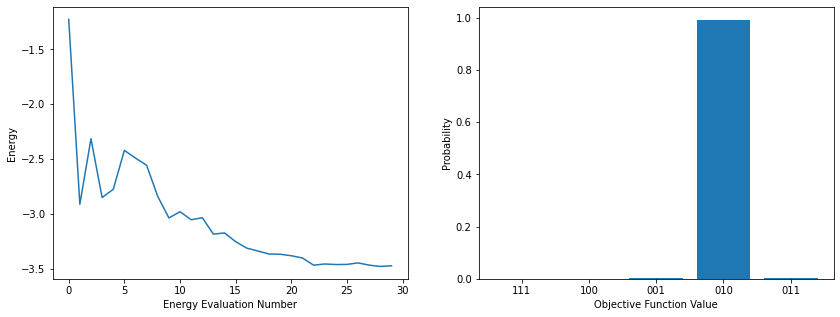

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(history['fvals'])
axs[1].bar(list(bitstrings.keys()), list(bitstrings.values()))
axs[0].set_xlabel("Energy Evaluation Number")
axs[0].set_ylabel("Energy")
axs[1].set_xlabel("Objective Function Value")
axs[1].set_ylabel("Probability")

#### From the bitstrings sampled, compute the corresponding objective function value, and then sort

In [35]:
samples = []
for x, probability in bitstrings.items():

    x = list(map(int, x)) # convert bitstring to list
    status = qp.is_feasible(x)
    fval = qp.objective.evaluate(x)

    samples.append((x, fval, probability, status))

sorted_samples = sorted(
    samples,
    key=lambda v: (1-v[3], qp.objective.sense.value * v[1]) # feasible: 0; infeasible: 1
)

print('\nsorted')
for sample in sorted_samples:
    print(sample)


sorted
([0, 1, 0], -2.0, 0.991375, True)
([1, 0, 0], 1.0, 0.000875, True)
([0, 0, 1], 3.0, 0.0045, True)
([0, 1, 1], 3.0, 0.002375, True)
([1, 1, 1], 4.0, 0.000875, True)


#### Get the solution with best objective function value

In [36]:
best = sorted_samples[0]
print('optimal value: {}'.format(best[0]))
print('optimal function value: {}'.format(best[1]))
print('probability of optimal value: {}'.format(best[2]))

optimal value: [0, 1, 0]
optimal function value: -2.0
probability of optimal value: 0.991375


In [37]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.6.0'

In [38]:
from qiskit.tools.jupyter import *

%qiskit_version_table
%qiskit_copyright